In [1]:
import numpy as np
import cupy as cp
from cupy import cutensor
from time import perf_counter_ns

def generateTestDataDim(p, q, numberOfCell, geometryDim=3, topologyDim=3):
    I = q * (q+1) * (q+2) / 6
    K = M = (p+1) * (p+2) * (p+3) / 6
    J = numberOfCell
    L = geometryDim
    return list(map(int, (I, J, K, L, M)))

dtype = np.float32

I, J, K, L, M = generateTestDataDim(3, 3, 100000)
print("Data benchmark:[I,J,K,L,M]=[{},{},{},{},{}]\n".format(I, J, K, L, M))
a = np.random.rand(I).astype(dtype)
b = np.random.rand(I, J, K, L).astype(dtype)
c = np.random.rand(I, J, M, L).astype(dtype)
d = np.random.rand(J).astype(dtype)

warmup=1
cycle=5

# for plot
time_data=[]
method_name=[]
acc=[]


Data benchmark:[I,J,K,L,M]=[10,100000,20,3,20]



In [2]:
print("Method: numpy.einsum (baseline)")
t_avg=0.0
for i in range(2):
    t1_start = perf_counter_ns()
    e0 = np.einsum('i, ijkl, ijml, j->jkm', a, b, c, d)
    t1_stop = perf_counter_ns()
    t1 = (t1_stop-t1_start) / 1e6
    print(f"Cycle {i+1}: {t1:5.5f} ms.")
    if i >= warmup:
        t_avg += t1
time = t_avg/(1)
print(f"Average time: {time:5.5f} ms")
baseline_time = time

time_data.append(time)
method_name.append("numpy.einsum")
acc.append(np.nan)

Method: numpy.einsum (baseline)
Cycle 1: 13829.34065 ms.
Cycle 2: 13969.82669 ms.
Average time: 13969.82669 ms


In [3]:
print("Method: cupy.einsum")

a_gpu = cp.asarray(a)
b_gpu = cp.asarray(b)
c_gpu = cp.asarray(c)
d_gpu = cp.asarray(d)

t_avg=0
for i in range(cycle):
    cp.cuda.Stream.null.synchronize()
    t1_start = perf_counter_ns()
    e_gpu = cp.empty((J, K, M)).astype(dtype)
    e_gpu[:, :, :] = cp.einsum(
        'i, ijkl, ijml, j->jkm', a_gpu, b_gpu, c_gpu, d_gpu)
    e1 = e_gpu.get()
    cp.cuda.Stream.null.synchronize()
    t1_stop = perf_counter_ns()
    assert(np.allclose(e1,e0))
    t1 = (t1_stop-t1_start) / 1e6
    print(f"Cycle {i+1}: {t1:5.5f} ms.")
    if i >= warmup:
        t_avg += t1
time = t_avg/(cycle-warmup)
acc_rate = baseline_time/time
print(f"Average time: {time:5.5f} ms")
print(f"Accelerate  : {acc_rate:5.5}")

time_data.append(time)
method_name.append("cupy.einsum")
acc.append(acc_rate)


Method: cupy.einsum
Cycle 1: 686.97516 ms.
Cycle 2: 96.90664 ms.
Cycle 3: 96.28794 ms.
Cycle 4: 95.66406 ms.
Cycle 5: 96.48352 ms.
Average time: 96.33554 ms
Accelerate  : 145.01


In [4]:
print("Method: cutensor-manual")

extent = {'i': I, 'j': J, 'k': K, 'm': M, 'l': L}
mode_a = ('i')
mode_b = ('i', 'j', 'k', 'l')
mode_c = ('i', 'j', 'm', 'l')
mode_d = ('j')
mode_e = ('j', 'k', 'm')
mode_f = ('i', 'j', 'k', 'm')
mode_g = ('i', 'j')
mode_a = cutensor.create_mode(*mode_a)
mode_b = cutensor.create_mode(*mode_b)
mode_c = cutensor.create_mode(*mode_c)
mode_d = cutensor.create_mode(*mode_d)
mode_e = cutensor.create_mode(*mode_e)
mode_f = cutensor.create_mode(*mode_f)
mode_g = cutensor.create_mode(*mode_g)

desc_a = cutensor.create_tensor_descriptor(a_gpu)
desc_b = cutensor.create_tensor_descriptor(b_gpu)
desc_c = cutensor.create_tensor_descriptor(c_gpu)
desc_d = cutensor.create_tensor_descriptor(d_gpu)
f_gpu = cp.empty((I, J, K, M)).astype(dtype)
g_gpu = cp.empty((I, J)).astype(dtype)
e_gpu = cp.empty((J, K, M)).astype(dtype)
desc_g = cutensor.create_tensor_descriptor(g_gpu)
desc_f = cutensor.create_tensor_descriptor(f_gpu)
desc_e = cutensor.create_tensor_descriptor(e_gpu)

t_avg=0
for i in range(cycle):
    cp.cuda.Stream.null.synchronize()
    t1_start = perf_counter_ns()
    desc_a = cutensor.create_tensor_descriptor(a_gpu)
    desc_b = cutensor.create_tensor_descriptor(b_gpu)
    desc_c = cutensor.create_tensor_descriptor(c_gpu)
    desc_d = cutensor.create_tensor_descriptor(d_gpu)
    f_gpu = cp.empty((I, J, K, M)).astype(dtype)
    g_gpu = cp.empty((I, J)).astype(dtype)
    e_gpu = cp.empty((J, K, M)).astype(dtype)
    desc_g = cutensor.create_tensor_descriptor(g_gpu)
    desc_f = cutensor.create_tensor_descriptor(f_gpu)
    desc_e = cutensor.create_tensor_descriptor(e_gpu)
    f_gpu = cutensor.contraction(1.0,
                                 b_gpu, desc_b, mode_b,
                                 c_gpu, desc_c, mode_c,
                                 0.0,
                                 f_gpu, desc_f, mode_f)
    g_gpu = cutensor.contraction(1.0,
                                 a_gpu, desc_a, mode_a,
                                 d_gpu, desc_d, mode_d,
                                 0.0,
                                 g_gpu, desc_g, mode_g)
    e_gpu = cutensor.contraction(1.0,
                                 f_gpu, desc_f, mode_f,
                                 g_gpu, desc_g, mode_g,
                                 0.0,
                                 e_gpu, desc_e, mode_e)
    cp.cuda.Stream.null.synchronize()
    t1_stop = perf_counter_ns()
    t1 = (t1_stop-t1_start) / 1e6
    e2 = e_gpu.get()
    assert(np.allclose(e2, e0))
    print(f"Cycle {i+1}: {t1:5.5f} ms")
    if i >= warmup:
        t_avg += t1
time = t_avg/(cycle-warmup)
acc_rate = baseline_time/time
print(f"Average time: {time:5.5f} ms")
print(f"Accelerate  : {acc_rate:5.5f}")

time_data.append(time)
method_name.append("cutensor")
acc.append(acc_rate)


Method: cutensor-manual
Cycle 1: 31.66085 ms
Cycle 2: 31.71498 ms
Cycle 3: 31.69063 ms
Cycle 4: 31.64048 ms
Cycle 5: 31.68321 ms
Average time: 31.68232 ms
Accelerate  : 440.93440


In [5]:
print("Method: cutensor-manual")

extent = {'i': I, 'j': J, 'k': K, 'm': M, 'l': L}
mode_a = ('i')
mode_b = ('i', 'j', 'k', 'l')
mode_c = ('i', 'j', 'm', 'l')
mode_d = ('j')
mode_e = ('j', 'k', 'm')
mode_f = ('i', 'j', 'k', 'l')
mode_g = ('j', 'k', 'm')
mode_a = cutensor.create_mode(*mode_a)
mode_b = cutensor.create_mode(*mode_b)
mode_c = cutensor.create_mode(*mode_c)
mode_d = cutensor.create_mode(*mode_d)
mode_e = cutensor.create_mode(*mode_e)
mode_f = cutensor.create_mode(*mode_f)
mode_g = cutensor.create_mode(*mode_g)

t_avg = 0
for i in range(cycle):
    cp.cuda.Stream.null.synchronize()
    t1_start = perf_counter_ns()
    desc_a = cutensor.create_tensor_descriptor(a_gpu)
    desc_b = cutensor.create_tensor_descriptor(b_gpu)
    desc_c = cutensor.create_tensor_descriptor(c_gpu)
    desc_d = cutensor.create_tensor_descriptor(d_gpu)
    f_gpu = cp.empty((I, J, K, L)).astype(dtype)
    e_gpu = cp.empty((J, K, M)).astype(dtype)
    g_gpu = cp.empty((J, K, M)).astype(dtype)
    desc_g = cutensor.create_tensor_descriptor(g_gpu)
    desc_f = cutensor.create_tensor_descriptor(f_gpu)
    desc_e = cutensor.create_tensor_descriptor(e_gpu)
    f_gpu = cutensor.contraction(1.0,
                                 a_gpu, desc_a, mode_a,
                                 b_gpu, desc_b, mode_b,
                                 0.0,
                                 f_gpu, desc_f, mode_f)
    g_gpu = cutensor.contraction(1.0,
                                 f_gpu, desc_f, mode_f,
                                 c_gpu, desc_c, mode_c,
                                 0.0,
                                 g_gpu, desc_g, mode_g)
    e_gpu = cutensor.contraction(1.0,
                                 g_gpu, desc_g, mode_g,
                                 d_gpu, desc_d, mode_d,
                                 0.0,
                                 e_gpu, desc_e, mode_e)
    cp.cuda.Stream.null.synchronize()
    t1_stop = perf_counter_ns()
    t1 = (t1_stop-t1_start) / 1e6
    e2 = e_gpu.get()
    assert(np.allclose(e2, e0))
    print(f"Cycle {i+1}: {t1:5.5f} ms")
    if i >= warmup:
        t_avg += t1
time = t_avg/(cycle-warmup)
acc_rate = baseline_time/time
print(f"Average time: {time:5.5f} ms")
print(f"Accelerate  : {acc_rate:5.5f}")

time_data.append(time)
method_name.append("cutensor-optimized")
acc.append(acc_rate)


Method: cutensor-manual
Cycle 1: 9.49210 ms
Cycle 2: 9.50723 ms
Cycle 3: 9.49529 ms
Cycle 4: 9.50916 ms
Cycle 5: 9.49529 ms
Average time: 9.50174 ms
Accelerate  : 1470.23852


(100.0, 3000.0)

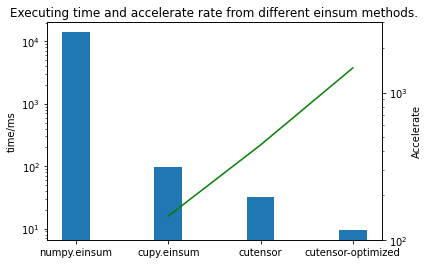

In [10]:
import matplotlib.pyplot as plt
plt.bar(method_name,height=time_data,label="Method",width=0.3)
plt.title("Executing time and accelerate rate from different einsum methods.")
plt.ylabel("time/ms")
plt.yscale("log")
sec = plt.gca().twinx()
sec.plot(acc,color='g')
sec.set_yscale("log")
sec.set_ylabel("Accelerate")
sec.set_ylim([1e2,3e3])
